In [1]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

train_data = []
train_labels = []

for i in range(1, 6):
    data_dict = unpickle(f'data_batch_{i}')
    if i == 1:
        train_data = data_dict[b'data']
        train_labels = data_dict[b'labels']
    else:
        train_data = np.vstack((train_data, data_dict[b'data']))
        train_labels = np.hstack((train_labels, data_dict[b'labels']))

test_dict = unpickle('test_batch')
test_data = test_dict[b'data']
test_labels = np.array(test_dict[b'labels'])

meta_dict = unpickle('batches.meta')
label_names = meta_dict[b'label_names']

train_data = train_data.reshape((len(train_data), 3, 32, 32)).transpose(0, 2, 3, 1)
train_data = train_data / 255.0
test_data = test_data.reshape((len(test_data), 3, 32, 32)).transpose(0, 2, 3, 1)
test_data = test_data / 255.0

# Diviser train_data en données étiquetées (x_labeled) et non étiquetées (x_unlabeled)
x_labeled, x_unlabeled, y_labeled, _ = train_test_split(train_data, train_labels, test_size=0.5, random_state=42)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Définir le modèle (le même que dans le premier notebook)
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10)
])

# Compiler le modèle
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Entraîner le modèle sur les données étiquetées
model.fit(x_train, y_train, epochs=20)

# Générer des pseudo-étiquettes pour les données non étiquetées
pseudo_labels = model.predict(x_unlabeled)
pseudo_labels = np.argmax(pseudo_labels, axis=1)

# Combiner les données étiquetées et les données non étiquetées avec les pseudo-étiquettes
x_combined = np.concatenate((x_train, x_unlabeled))
y_combined = np.concatenate((y_train.flatten(), pseudo_labels))

# Réentraîner le modèle sur le jeu de données combiné
history = model.fit(x_combined, y_combined, epochs=20)

# Enregistrer l'historique d'entraînement
with open('history2.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Évaluer le modèle sur les données de test
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')


Epoch 1/20
1563/1563 [==============================] - 31s 14ms/step - loss: 1.5154 - accuracy: 0.4796
Epoch 2/20
1563/1563 [==============================] - 21s 13ms/step - loss: 0.9260 - accuracy: 0.6763
Epoch 3/20
1563/1563 [==============================] - 20s 13ms/step - loss: 0.7470 - accuracy: 0.7446
Epoch 4/20
1563/1563 [==============================] - 21s 13ms/step - loss: 0.6407 - accuracy: 0.7821
Epoch 5/20
1563/1563 [==============================] - 20s 13ms/step - loss: 0.5608 - accuracy: 0.8105
Epoch 6/20
1563/1563 [==============================] - 21s 13ms/step - loss: 0.4943 - accuracy: 0.8325
Epoch 7/20
1563/1563 [==============================] - 21s 13ms/step - loss: 0.4414 - accuracy: 0.8518
Epoch 8/20
1563/1563 [==============================] - 21s 13ms/step - loss: 0.3981 - accuracy: 0.8636
Epoch 9/20
1563/1563 [==============================] - 21s 13ms/step - loss: 0.3645 - accuracy: 0.8745
Epoch 10/20
1563/1563 [==============================] - 21s 13m

313/313 [==============================] - 2s 5ms/step


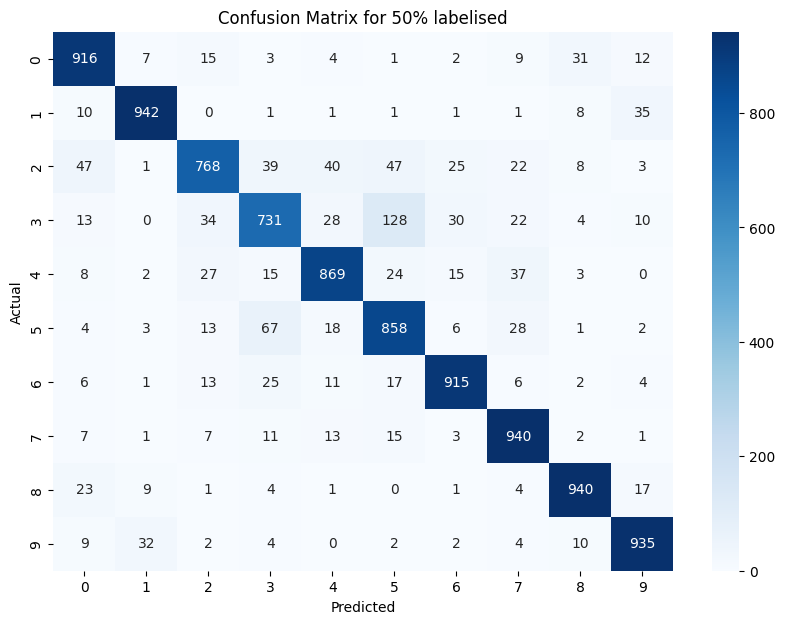

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

pred_labels = np.argmax(model.predict(test_data), axis=1)

cm = confusion_matrix(test_labels, pred_labels)

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(cm, 'Confusion Matrix for 50% labelised')